In [2]:
!pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.3 MB/s 
     |████████████████████████████████| 51 kB 355 kB/s 
     |████████████████████████████████| 251 kB 8.6 MB/s 


In [3]:
# !pip install neuralprophet
# !pip install neuralprophet[live]
!pip install git+https://github.com/ourownstory/neural_prophet.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-i8wc25z8
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-i8wc25z8
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 4.2 MB/s 
  Created wheel for neuralprophet: filename=neuralprophet-0.3.3-py3-none-any.whl size=80595 sha256=7b9fc50f900faaccf9b35d68dcd79141dc6860938c86538b9d82a9930794983c
  Stored in directory: /tmp/pip-ephem-wheel-cache-fxvo4hi0/wheels/bc/d0/dd/f2b1133865669ed9b544f6f1ff9155aedf57c9dbfc72ce211e
Successfully built neuralprophet
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successf

In [ ]:
from neuralprophet import NeuralProphet
import pandas as pd
import numpy as np

from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/한국품질재단 폴더/final(colab)/dataset.csv')

In [ ]:
df.columns = ['ds', 'y', '금리', 'ex_종가']

In [ ]:
df = df[['ds','y']]
df['ds'] = pd.to_datetime(df['ds'])

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



In [ ]:
df

,ds,y
0,2017-01-02,18645
1,2017-01-03,18776
2,2017-01-04,18738
3,2017-01-05,18716
4,2017-01-06,18815
...,...,...
1304,2022-04-25,26818
1305,2022-04-26,26916
1306,2022-04-27,26690
1307,2022-04-28,26960


In [ ]:
# train test split
cutoff = "2021-12-31" #데이터 분할 기준
train = df[df['ds']<cutoff]
test = df[df['ds']>=cutoff]

test = test.reset_index(drop=True)

In [ ]:
test['ds']

0    2022-01-03
1    2022-01-04
2    2022-01-05
3    2022-01-06
4    2022-01-07
        ...    
75   2022-04-25
76   2022-04-26
77   2022-04-27
78   2022-04-28
79   2022-04-29
Name: ds, Length: 80, dtype: datetime64[ns]

In [ ]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['y']
scaled_train = scaler.fit_transform(train[scale_cols])
scaled_train = pd.DataFrame(scaled_train)
scaled_train.columns = ['y']
scaled_train['ds'] = train['ds']
scaled_train = scaled_train[['ds','y']]

scaler = MinMaxScaler()
scale_cols = ['y']
scaled_test = scaler.fit_transform(test[scale_cols])
scaled_test = pd.DataFrame(scaled_test)
scaled_test.columns = ['y']
scaled_test['ds'] = test['ds']
scaled_test = scaled_test[['ds','y']]

In [ ]:
scaled_test

,ds,y
0,2022-01-03,1.000000
1,2022-01-04,0.997214
2,2022-01-05,0.881861
3,2022-01-06,0.807746
4,2022-01-07,0.890220
...,...,...
75,2022-04-25,0.106994
76,2022-04-26,0.134299
77,2022-04-27,0.071329
78,2022-04-28,0.146559


In [ ]:
# 차분

df = df.copy(deep=True)
df["l"] = np.append(0, df["y"].values[1:] - df["y"].values[:-1])
df=df[['ds','y','l']]
df.head(3)

,ds,y,l
0,2017-01-02,18645,0
1,2017-01-03,18776,131
2,2017-01-04,18738,-38


In [ ]:
# 차분 반영 모델

m = NeuralProphet(
n_forecasts= 30,
growth='off', # 추세 유형 설정(linear, discontinuous, off 중 선택 가능)

yearly_seasonality=False, #년간 계절성 설정

weekly_seasonality=False, #주간 계절성 설정

daily_seasonality=False, #일간 계절성 설정

batch_size=64,#배치 사이즈 설정

epochs=100,#학습 횟수 설정

learning_rate=0.1, # 학습률 설정

n_lags= 1, #1시간 전 데이터로 설정

)

#독립 변인(변수) 추가 및 정규화
m = m.add_lagged_regressor(names=["l"], normalize="minmax") 

# 학습데이터, 검증데이터 분리
# train, test = m.split_df(df, freq='d', valid_p = 0.10)

#학습 수행
metrics = m.fit(train, freq='d', validation_df=test, progress='plot')

INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (1)


ValueError: ignored

In [ ]:
m = NeuralProphet(
    n_forecasts= 126, # 예측(1:10분)
    n_lags = 2, # (1:10분) 뒤 regressor 지연 반영
    n_changepoints=100,
    trend_reg=0.05,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    d_hidden=128, #은닉층 뉴런 설정
    learning_rate=0.01, #학습률 설정
    batch_size= 128, #배치 사이즈 설정
    epochs=200)

#학습 수행
metrics = m.fit(train_df, freq='d', validation_df=test_df, progress='plot')

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.769% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d
INFO - (NP.forecaster.__handle_missing_data) - 595 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 595 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 595 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 48 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 48 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 48 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality.

In [ ]:
metrics

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,1.110487,26760.145932,33318.951500,0.000000,1.852387,40198.601562,47367.917969
1,1.094028,26458.069991,32963.567624,0.000000,1.779447,38894.453125,46026.453125
2,1.075584,26118.595818,32562.298261,0.000000,1.693246,37343.140625,44426.968750
3,1.053293,25707.876953,32081.417154,0.000000,1.589920,35458.062500,42485.781250
4,1.026764,25216.692202,31507.157615,0.000000,1.468351,33252.425781,40163.320312
...,...,...,...,...,...,...,...
195,0.001716,763.657144,1015.806791,0.001372,0.002362,897.768372,1192.178467
196,0.001716,763.646754,1015.683755,0.001378,0.002362,897.666565,1192.023071
197,0.001716,763.639001,1015.219880,0.001383,0.002363,897.942993,1192.470947
198,0.001716,763.636197,1015.402492,0.001386,0.002363,897.960876,1192.494873


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.05% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 88.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d
INFO - (NP.forecaster.__handle_missing_data) - 48 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 48 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 48 NaN values in column y were auto-imputed.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py:2532: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `

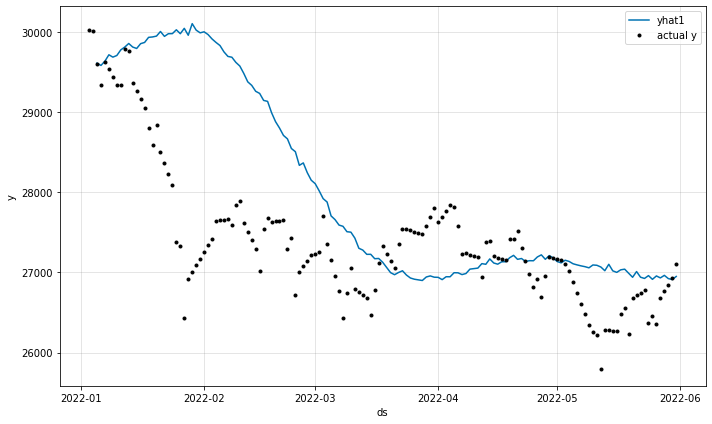

In [ ]:
forecast = m.predict(test_df)
fig = m.plot(forecast[['ds', 'y', 'yhat1']])

In [ ]:
df_future = m.make_future_dataframe(df)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d


In [ ]:
df_future

,ds,y
0,2022-05-30,26935
1,2022-05-31,27100
2,2022-06-01,None
3,2022-06-02,None
4,2022-06-03,None
...,...,...
123,2022-09-30,None
124,2022-10-01,None
125,2022-10-02,None
126,2022-10-03,None


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.219% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.219% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py:2532: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/neuralprophet/forecaster.py:2533: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

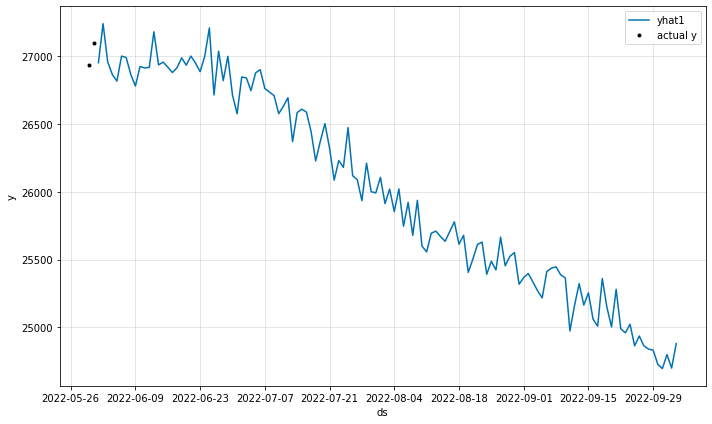

In [ ]:
forecast = m.predict(df_future)
fig_forecast = m.plot(forecast)

In [ ]:
forecast.head(10)

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,ar120,ar121,ar122,ar123,ar124,ar125,ar126,trend,season_yearly,season_weekly
0,2022-05-30,26935.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
1,2022-05-31,27100.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
2,2022-06-01,NaN,26952.15625,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,27497.455078,26.387821,19.391972
3,2022-06-02,NaN,None,NaN,27240.623047,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,27482.125,44.168938,1.612477
4,2022-06-03,NaN,None,NaN,None,NaN,26960.361328,NaN,None,NaN,...,None,None,None,None,None,None,None,27466.789062,62.55431,-1.073196
5,2022-06-04,NaN,None,NaN,None,NaN,None,NaN,26865.078125,NaN,...,None,None,None,None,None,None,None,27451.460938,81.472336,-7.929156
6,2022-06-05,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,27436.125,100.845421,-12.451093
7,2022-06-06,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,27420.792969,120.591049,-20.649239
8,2022-06-07,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,27405.457031,140.62236,21.098234
9,2022-06-08,NaN,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,27390.128906,160.848831,19.391972


In [ ]:
forecast = m.predict(df_future, raw=True, decompose=False)

WARNING - (NP.forecaster.predict) - Raw forecasts are incompatible with plotting utilities
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.219% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.219% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d


In [ ]:
forecast = forecast.transpose()

In [ ]:
forecast

,0
ds,2022-06-01 00:00:00
step0,26952.15625
step1,27240.623047
step2,26960.361328
step3,26865.078125
...,...
step121,24727.710938
step122,24696.046875
step123,24799.09375
step124,24699.376953


In [ ]:
forecast = forecast[1:]
forecast = forecast.reset_index()
forecast

,index,0
0,step0,26952.15625
1,step1,27240.623047
2,step2,26960.361328
3,step3,26865.078125
4,step4,26816.527344
...,...,...
121,step121,24727.710938
122,step122,24696.046875
123,step123,24799.09375
124,step124,24699.376953


In [ ]:
df_future

,ds,y
0,2022-05-30,26935
1,2022-05-31,27100
2,2022-06-01,NaN
3,2022-06-02,NaN
4,2022-06-03,NaN
...,...,...
123,2022-09-30,NaN
124,2022-10-01,NaN
125,2022-10-02,NaN
126,2022-10-03,NaN


In [ ]:
df_future_forecast = df_future[2:]
# df_future_forecast
df_future_forecast['yhat'] = forecast[0]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until



In [ ]:
df_future_forecast

,ds,y,yhat
2,2022-06-01,NaN,26960.361328
3,2022-06-02,NaN,26865.078125
4,2022-06-03,NaN,26816.527344
5,2022-06-04,NaN,27000.855469
6,2022-06-05,NaN,26991.058594
...,...,...,...
123,2022-09-30,NaN,24799.09375
124,2022-10-01,NaN,24699.376953
125,2022-10-02,NaN,24880.378906
126,2022-10-03,NaN,NaN


In [ ]:
df_future_forecast = df_future_forecast.drop(['y'], axis=1)
df_future_forecast = df_future_forecast.rename(columns={'yhat':'y'})
df_future_forecast.to_csv("nn_ko_test.csv",index=False)

# 최종코드

In [36]:
from pykrx import stock

import pandas as pd
import numpy as np
from matplotlib import pyplot

# neural Prophet
from neuralprophet import NeuralProphet


# Prophet 시각화 도구
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

# 평가지표
from sklearn.metrics import mean_absolute_error, mean_squared_error

# scaling
from sklearn.preprocessing import MinMaxScaler

def RMSE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.sqrt(np.mean((y_test - y_pred)**2))

def datasplit_ts(df, cut):
    df.columns = ['ds', 'y']
    train_df = df[df['ds']<=cut]
    test_df = df[df['ds']>cut]
    return train_df, test_df

# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/My Drive/한국품질재단 폴더/final(colab)/kodex_kospi.csv')

kodex_df = stock.get_market_ohlcv_by_date("20170101", "20220531", "140710")
kodex_df = kodex_df.reset_index()
df = kodex_df[['날짜','종가']]

# 데이터 컬럼 설정, 데이터 분할
train_df, test_df = datasplit_ts(df, '2021-12-31')


# 스케일링
scaler = MinMaxScaler()
scale_cols = ['y']
scaled_train = scaler.fit_transform(train_df[scale_cols])
scaled_train = pd.DataFrame(scaled_train)
scaled_train.columns = ['y']
scaled_train['ds'] = train_df['ds']
scaled_train = scaled_train[['ds','y']]

scaler = MinMaxScaler()
scale_cols = ['y']
scaled_test = scaler.fit_transform(test_df[scale_cols])
scaled_test = pd.DataFrame(scaled_test)
scaled_test.columns = ['y']
test_df = test_df.reset_index()
scaled_test['ds'] = test_df['ds']
scaled_test = scaled_test[['ds','y']]

m = NeuralProphet(
    n_forecasts= 126, # 예측(1:10분)
    n_lags = 2, # (1:10분) 뒤 regressor 지연 반영
    n_changepoints=100,
    trend_reg=0.05,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    d_hidden=128, #은닉층 뉴런 설정
    learning_rate=0.01, #학습률 설정
    batch_size= 128, #배치 사이즈 설정
    epochs=200)

#학습 수행
metrics = m.fit(scaled_train, freq='d', validation_df=scaled_test, progress='plot')

# forecast = m.predict(test_df)

# df_future = m.make_future_dataframe(df)

# forecast = m.predict(df_future)

# forecast = m.predict(df_future, raw=True, decompose=False)

# forecast = forecast.transpose()

# forecast = forecast[1:]
# forecast = forecast.reset_index()

# df_future_forecast = df_future[2:]
# df_future_forecast['yhat'] = forecast[0]

# df_future_forecast = df_future_forecast.drop(['y'], axis=1)
# df_future_forecast = df_future_forecast.rename(columns={'yhat':'y'})

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 95.769% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - d
INFO - (NP.forecaster.__handle_missing_data) - 595 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 595 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 595 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 48 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 48 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 48 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality.

In [30]:
train_df, test_df = datasplit_ts(df, '2021-12-31')

In [32]:
scaler = MinMaxScaler()
scale_cols = ['y']
scaled_test = scaler.fit_transform(test_df[scale_cols])
scaled_test = pd.DataFrame(scaled_test)
scaled_test.columns = ['y']
test_df = test_df.reset_index()
scaled_test['ds'] = test_df['ds']
scaled_test

,y,ds
0,1.000000,2022-01-03
1,0.952731,2022-01-04
2,0.778839,2022-01-05
3,0.636719,2022-01-06
4,0.766317,2022-01-07
...,...,...
96,0.175145,2022-05-25
97,0.074973,2022-05-26
98,0.099233,2022-05-27
99,0.167319,2022-05-30


In [29]:
scaler = MinMaxScaler()
scale_cols = ['y']
scaled_test = scaler.fit_transform(test_df[scale_cols])
scaled_test = pd.DataFrame(scaled_test)
scaled_test.columns = ['y']

test_df = test_df.reset_index()

# scaled_test['ds'] = test_df['ds']
# scaled_test = scaled_test[['ds','y']]

In [28]:
scaled_test

,y
0,1.000000
1,0.952731
2,0.778839
3,0.636719
4,0.766317
...,...
96,0.175145
97,0.074973
98,0.099233
99,0.167319


In [ ]:
df_future_forecast

,ds,y
2,2022-06-01,7878.198242
3,2022-06-02,7890.261719
4,2022-06-03,7925.476074
5,2022-06-04,7900.175293
6,2022-06-05,7936.431152
...,...,...
123,2022-09-30,7337.372559
124,2022-10-01,7297.544434
125,2022-10-02,7281.100098
126,2022-10-03,NaN


In [ ]:
df_future_forecast.to_csv("nn_sc_yhat.csv",index=False)